# Статистика по индексу MIX на основе размера тела свечи.

Статистика по направлениям (растущая, падающая) после свечи с аномальным (превышающим 75 перцентиль за `PERIOD` свечей) телом свечи.  
Проверка гипотезы, что после свечи с аномальным превышением размера тела, следует свеча в том же направлении.

In [53]:
PERIOD = 30

Подключение гугл диска

In [54]:
# Подключение google drive для colab

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

### Подключение к БД.

In [55]:
import pandas as pd
import numpy as np
import sqlite3

In [56]:
# Создание соединения из colab с БД на google drive
# connection = sqlite3.connect(r'/content/drive/MyDrive/data_quote_db/MIX_futures_day.db', check_same_thread=True) 

In [57]:
# Создание соединения из JN с БД на локальной машине
connection = sqlite3.connect(r'c:\Users\Alkor\gd\data_quote_db\MIX_futures_day.db', check_same_thread=True) 

Загрузка данных в таблицу pandas.

In [58]:
with connection:
  df = pd.read_sql('SELECT * FROM Day', connection)  # Загрузка данных из БД

print(df.to_string(max_rows=6, max_cols=25))  # Проверка того, что загрузилось

       TRADEDATE      SECID      OPEN       LOW      HIGH     CLOSE  VOLUME  OPENPOSITION SHORTNAME    LSTTRADE
0     2015-01-05  MXH5_2015  142000.0  138525.0  145950.0  145150.0    2587         12938  MIX-3.15  2015-03-16
1     2015-01-06  MXH5_2015  144750.0  144350.0  149900.0  149900.0    2953         12760  MIX-3.15  2015-03-16
2     2015-01-08  MXH5_2015  149500.0  148200.0  158200.0  156025.0    5567         15098  MIX-3.15  2015-03-16
...          ...        ...       ...       ...       ...       ...     ...           ...       ...         ...
2303  2024-03-14       MXH4  332925.0  329275.0  332975.0  330650.0   60896         94590  MIX-3.24  2024-03-21
2304  2024-03-15       MXH4  330600.0  329850.0  332325.0  331250.0   32069         84632  MIX-3.24  2024-03-21
2305  2024-03-18       MXH4  330900.0  329775.0  333150.0  330525.0   36079         66916  MIX-3.24  2024-03-21


Конвертация типа дат и сортировка по дате.

In [59]:
df = df.drop(['SECID', 'VOLUME', 'OPENPOSITION', 'SHORTNAME', 'LSTTRADE'], axis=1)  # Очистка от неиспользуемых полей
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
# df['LSTTRADE'] = pd.to_datetime(df['LSTTRADE'])
df = df.dropna().reset_index(drop=True)
df = df.sort_values (by='TRADEDATE', ascending=True)

Добавление колонки направления бара.  
0 - понижающийся бар  
1 - повышающийся бар

In [60]:
df['Up/Down'] = df.apply(lambda x: 'Up' if (x['OPEN'] < x['CLOSE']) else 'Down', axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка
print('\n', df.value_counts("Up/Down"))  # Подсчет количества баров на повышение и понижение

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down
0    2015-01-05  142000.0  138525.0  145950.0  145150.0      Up
1    2015-01-06  144750.0  144350.0  149900.0  149900.0      Up
2    2015-01-08  149500.0  148200.0  158200.0  156025.0      Up
...         ...       ...       ...       ...       ...     ...
2303 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down
2304 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up
2305 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down

 Up/Down
Up      1203
Down    1103
Name: count, dtype: int64


Размер тела свечи.  
Создание колонки с размером тела свечи (Body). Размер тела свечи записан по модулю.

In [61]:
df['Body'] = df.apply(lambda x: abs(x['OPEN'] - x['CLOSE']), axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body
0    2015-01-05  142000.0  138525.0  145950.0  145150.0      Up  3150.0
1    2015-01-06  144750.0  144350.0  149900.0  149900.0      Up  5150.0
2    2015-01-08  149500.0  148200.0  158200.0  156025.0      Up  6525.0
...         ...       ...       ...       ...       ...     ...     ...
2303 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0
2304 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0
2305 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down   375.0


Создание колонок с предыдущими размерами свечей для вычисления перцентилей.  
Количество дней для вычисления перцентилей берется с переменной PERIOD.

In [62]:
for i in range(1, PERIOD + 1):
  df[f'Body_{i}'] = df['Body'].shift(i)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body  Body_1  Body_2  Body_3  Body_4  Body_5  ...  Body_19  Body_20  Body_21  Body_22  Body_23  Body_24  Body_25  Body_26  Body_27  Body_28  Body_29  Body_30
0    2015-01-05  142000.0  138525.0  145950.0  145150.0      Up  3150.0     NaN     NaN     NaN     NaN     NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
1    2015-01-06  144750.0  144350.0  149900.0  149900.0      Up  5150.0  3150.0     NaN     NaN     NaN     NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
2    2015-01-08  149500.0  148200.0  158200.0  156025.0      Up  6525.0  5150.0  3150.0     NaN     NaN     NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
...         ...       ...       ...       ...       ...     ...     ...     ...     ...     ...     

Очистка DF от NaN.  


In [63]:
df = df.dropna().reset_index(drop=True)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body  Body_1  Body_2  Body_3  Body_4  Body_5  ...  Body_19  Body_20  Body_21  Body_22  Body_23  Body_24  Body_25  Body_26  Body_27  Body_28  Body_29  Body_30
0    2015-02-17  181100.0  179075.0  185850.0  179875.0    Down  1225.0  3350.0  2975.0  3100.0  2250.0   975.0  ...   5000.0   1325.0   2175.0   3400.0    125.0   1150.0   2850.0   1900.0    600.0   6525.0   5150.0   3150.0
1    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  1225.0  3350.0  2975.0  3100.0  2250.0  ...   5825.0   5000.0   1325.0   2175.0   3400.0    125.0   1150.0   2850.0   1900.0    600.0   6525.0   5150.0
2    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  2075.0  1225.0  3350.0  2975.0  3100.0  ...     50.0   5825.0   5000.0   1325.0   2175.0   3400.0    125.0   1150.0   2850.0   1900.0    600.0   6525.0
...         ...       ...       ...       ...       ...     ...     ...     ...     ...     ...     

Создание колонки с расчетом 75 перцентиля (per75) и удаление колонок с предыдущими значениями тел свечей.

In [64]:
# Создание колонки с расчетом 75 перцентиля (per75) и удаление колонок с предыдущими значениями тел свечей.
df['per75'] = df.apply(lambda x: np.percentile([x[f'Body_{i}'] for i in range(1, PERIOD + 1)], 75), axis=1)
drop_column_lst = [f'Body_{i}' for i in range(1, PERIOD + 1)]
df = df.drop(drop_column_lst, axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75
0    2015-02-17  181100.0  179075.0  185850.0  179875.0    Down  1225.0  3387.50
1    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50
2    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25
...         ...       ...       ...       ...       ...     ...     ...      ...
2273 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75
2274 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50
2275 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down   375.0  2131.25


Создание колонки с маркерами выбросов больше 75 перцентиля (Over_per75).  
0 - нет превышения 75 перцентиля по размеру тела свечи.  
1 - есть превышение 75 перцентиля по размеру тела свечи.

In [65]:
df['Over_per75'] = df.apply(lambda x: True if (x['Body'] > x['per75']) else False, axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75
0    2015-02-17  181100.0  179075.0  185850.0  179875.0    Down  1225.0  3387.50       False
1    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False
2    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False
...         ...       ...       ...       ...       ...     ...     ...      ...         ...
2273 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75        True
2274 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50       False
2275 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down   375.0  2131.25       False


Создание колонки с маркерами выбросов больше 75 пецентиля для предыдущего бара (prev_Over_per75).  
Создание колонки с направлением предыдущнго бара (prev_Up/Down).

In [66]:
df['prev_Up/Down'] = df['Up/Down'].shift(1)
df['prev_Over_per75'] = df['Over_per75'].shift(1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75 prev_Up/Down prev_Over_per75
0    2015-02-17  181100.0  179075.0  185850.0  179875.0    Down  1225.0  3387.50       False         None             NaN
1    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False         Down           False
2    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False           Up           False
...         ...       ...       ...       ...       ...     ...     ...      ...         ...          ...             ...
2273 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75        True         Down           False
2274 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50       False         Down            True
2275 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down   375.0  2131.25       False           Up           False


Очитка от NaN и смена типа на int

In [67]:
df = df.dropna().reset_index(drop=True)
# df[['prev_Up/Down', 'prev_Over_per75']] = df[['prev_Up/Down', 'prev_Over_per75']].astype(int)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75 prev_Up/Down prev_Over_per75
0    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False         Down           False
1    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False           Up           False
2    2015-02-20  180525.0  178925.0  183200.0  180575.0      Up    50.0  3156.25       False         Down           False
...         ...       ...       ...       ...       ...     ...     ...      ...         ...          ...             ...
2272 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75        True         Down           False
2273 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50       False         Down            True
2274 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down   375.0  2131.25       False           Up           False


Проверка гипотезы, что после свечи с аномальным превышением размера тела, следует свеча в том же направлении.  
-1 - гипотеза не подтверждается.  
0 - Без проверки гипотезы на этой свече (нет условия анамального размера тела предыдущей свечи).  
1 - Гипотеза подтверждается.  

In [68]:
def rez(up_down, prev_up_down, prev_over_per75):
    if (up_down == prev_up_down) and (prev_over_per75 == 1):
        return 1
    elif (up_down != prev_up_down) and (prev_over_per75 == 1):
        return -1
    else:
        return 0

df['Rez'] = df.apply(lambda x: rez(x['Up/Down'], x['prev_Up/Down'], x['prev_Over_per75']), axis=1)
print(df.to_string(max_rows=6, max_cols=25))  # Проверка
print('\n', df.value_counts("Rez"))

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75 prev_Up/Down prev_Over_per75  Rez
0    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False         Down           False    0
1    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False           Up           False    0
2    2015-02-20  180525.0  178925.0  183200.0  180575.0      Up    50.0  3156.25       False         Down           False    0
...         ...       ...       ...       ...       ...     ...     ...      ...         ...          ...             ...  ...
2272 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75        True         Down           False    0
2273 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50       False         Down            True   -1
2274 2024-03-18  330900.0  329775.0  333150.0  330525.0    Down   375.0  2131.25       False           Up      

По результату видно, что количественная оценка не подтверждает гипотезу, что после свечи с аномальным превышением размера тела, следует свеча в том же направлении.  

---

Количественная оценка не может быть показателем для применения на практике т.к. аномальные размеры тела свечи в периоды спокойного рынка и в периоды высокой волатильности, очень сильно различаются.  
Подсчитаем сумму размеров тел свечей идущих следом за свечами с аномальным размером тела. С учетом направления. Своего рода симуляция торговли. Результат получен положительный.  

In [69]:
def rez_value(body, rez):
    if rez == 1:
        return body
    elif rez == -1:
        return -body
    else:
        return 0

df_body = df.copy(deep=True)  # Создание копии
df_body['Rez_value'] = df_body.apply(lambda x: rez_value(x['Body'], x['Rez']), axis=1)
df_body["Rez_cum"] = df_body["Rez_value"].cumsum()
print(df_body.to_string(max_rows=6, max_cols=25))  # Проверка
print('\n', df_body[['Rez_value']].sum())  # Сумма всех элементов в колонке

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75 prev_Up/Down prev_Over_per75  Rez  Rez_value   Rez_cum
0    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False         Down           False    0        0.0       0.0
1    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False           Up           False    0        0.0       0.0
2    2015-02-20  180525.0  178925.0  183200.0  180575.0      Up    50.0  3156.25       False         Down           False    0        0.0       0.0
...         ...       ...       ...       ...       ...     ...     ...      ...         ...          ...             ...  ...        ...       ...
2272 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75        True         Down           False    0        0.0  224500.0
2273 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50       False         Down       

Строим график симуляции торговли по гипотезе.

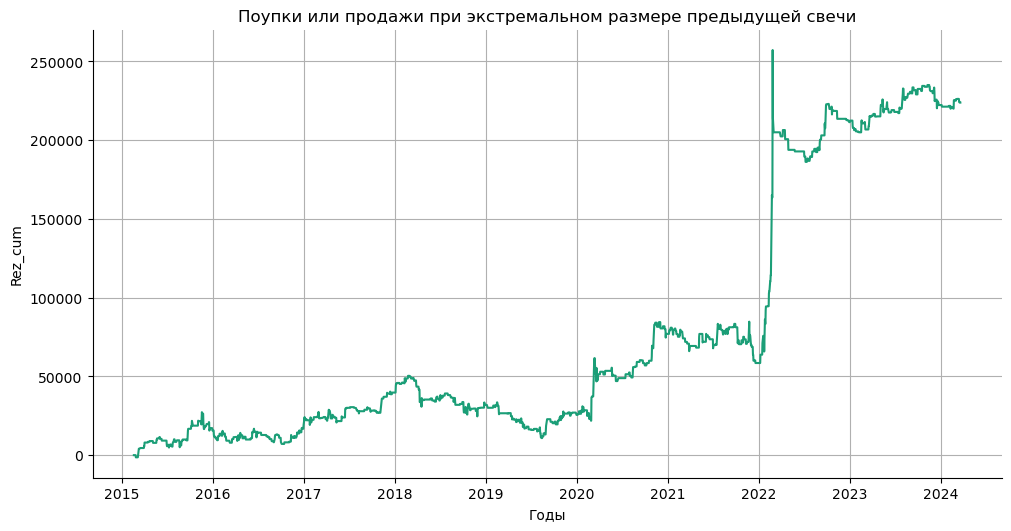

In [70]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Rez_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_body.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Годы')
plt.title('Поупки или продажи при экстремальном размере предыдущей свечи')
plt.grid()
_ = plt.ylabel('Rez_cum')

График не по годам, а по количеству сделок

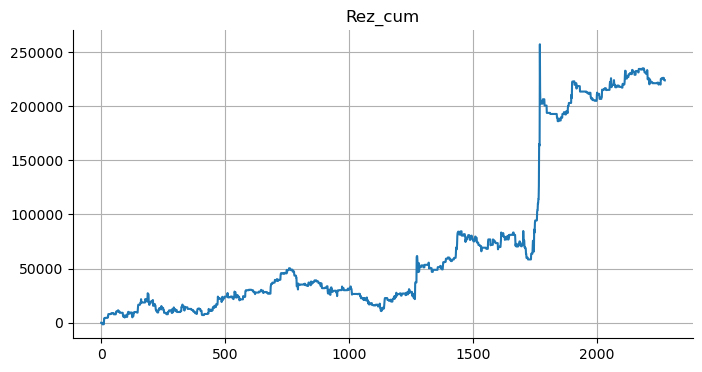

In [71]:
from matplotlib import pyplot as plt
df_body['Rez_cum'].plot(kind='line', figsize=(8, 4), title='Rez_cum')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid()

## Выводы:  
1. Гипотеза: после свечи с аномальным превышением размера тела, следует свеча в том же направлении, не подтвердилась в количественном выражении.  
2. Симуляция торговли с использованием гипотезы дала положительный результат.  
3. Если рассматривать график результатов симуляции торговли, то можно сделать вывод, что положительный результат торговли достигается в периоды повышенной волатильности рынка (COVID-19, СВО).

---

## Добавление симуляции торговли по дням недели


Создание и заполнение колонки с торговым днем недели (Work_day).  
0 - Понедельник  
1 - Вторник  
и т.д.

In [72]:
df['Work_day'] = df['TRADEDATE'].dt.weekday

df[['Work_day']] = df[['Work_day']].astype(int)
df = df.sort_values(by='TRADEDATE', ascending=True)  # Сортировка по возрастанию
print(df.to_string(max_rows=6, max_cols=25))  # Проверка

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75 prev_Up/Down prev_Over_per75  Rez  Work_day
0    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False         Down           False    0         2
1    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False           Up           False    0         3
2    2015-02-20  180525.0  178925.0  183200.0  180575.0      Up    50.0  3156.25       False         Down           False    0         4
...         ...       ...       ...       ...       ...     ...     ...      ...         ...          ...             ...  ...       ...
2272 2024-03-14  332925.0  329275.0  332975.0  330650.0    Down  2275.0  1943.75        True         Down           False    0         3
2273 2024-03-15  330600.0  329850.0  332325.0  331250.0      Up   650.0  2187.50       False         Down            True   -1         4
2274 2024-03-18  330900.0  329775.0  3331

Создание колонки с результатом при продажах при экстремальном размере тела предыдущей свечи на понижение и покупки в понедельник вторник среду.

In [73]:
def rez_value(prev_Over_per75, prev_Up_Down, Up_Down, Work_day, body):
    if (prev_Over_per75 == True) and (prev_Up_Down == 'Down') and (Up_Down == 'Down'):
      return body
    elif (prev_Over_per75 == True) and (prev_Up_Down == 'Down') and (Up_Down == 'Up'):
      return -body
    elif (Work_day < 3) and (Up_Down == 'Up'):
      return body
    elif (Work_day < 3) and (Up_Down == 'Down'):
      return -body
    else:
      return 0

df['Rez_value'] = df.apply(lambda x: rez_value(x['prev_Over_per75'],
                                               x['prev_Up/Down'],
                                               x['Up/Down'],
                                               x['Work_day'],
                                               x['Body'], ), axis=1)
df["Rez_cum"] = df["Rez_value"].cumsum()
print(df.to_string(max_rows=20, max_cols=25))  # Проверка
print('\n', df[['Rez_value']].sum())  # Сумма всех элементов в колонке

      TRADEDATE      OPEN       LOW      HIGH     CLOSE Up/Down    Body    per75  Over_per75 prev_Up/Down prev_Over_per75  Rez  Work_day  Rez_value   Rez_cum
0    2015-02-18  179850.0  179750.0  185000.0  181925.0      Up  2075.0  3387.50       False         Down           False    0         2     2075.0    2075.0
1    2015-02-19  182250.0  176750.0  183475.0  180700.0    Down  1550.0  3306.25       False           Up           False    0         3        0.0    2075.0
2    2015-02-20  180525.0  178925.0  183200.0  180575.0      Up    50.0  3156.25       False         Down           False    0         4        0.0    2075.0
3    2015-02-24  180300.0  176500.0  181800.0  178250.0    Down  2050.0  3156.25       False           Up           False    0         1    -2050.0      25.0
4    2015-02-25  178200.0  173450.0  179100.0  174750.0    Down  3450.0  3156.25        True         Down           False    0         2    -3450.0   -3425.0
5    2015-02-26  175000.0  174075.0  177925.0  17640

Строим график симуляции торговли по гипотезе.

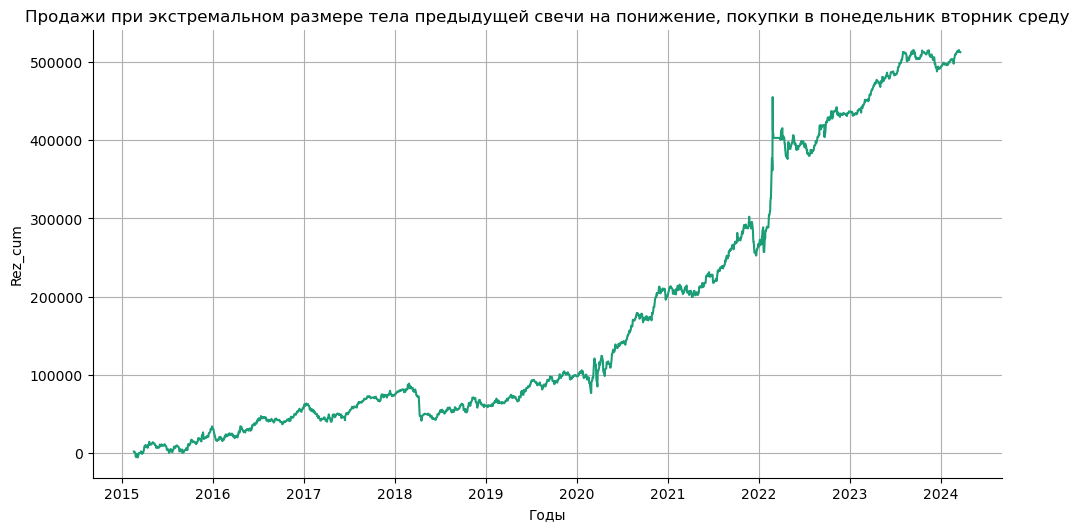

In [74]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['TRADEDATE']
  ys = series['Rez_cum']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('TRADEDATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Годы')
plt.title('Продажи при экстремальном размере тела предыдущей свечи на понижение, покупки в понедельник вторник среду')
plt.grid()
_ = plt.ylabel('Rez_cum')

---

## Сравнение доходности стратегии с индексом полной доходности MCFTR.

In [75]:
# pip install apimoex  # Инсталяция библиотеки для запросов к серверу MOEX

In [76]:
import apimoex
import requests
from datetime import datetime, timedelta, date

In [77]:
start_date = '2015-01-01'
end_date = (datetime.now().date() - timedelta(days=1)).strftime("%Y-%m-%d")  #

with requests.Session() as session:
    data = apimoex.get_market_candles(
        session=session,
        security="mcftr",
        market="index",
        engine="stock",
        interval=24,
        start = start_date,
        end = end_date,
        columns = ('begin', 'open', 'close', 'high', 'low',),
    )
    df_idx = pd.DataFrame(data)

print(df_idx)

                    begin     open    close     high      low
0     2016-11-18 00:00:00  2856.55  2856.55  2856.55  2856.55
1     2016-11-21 00:00:00  2885.25  2885.25  2885.25  2885.25
2     2016-11-22 00:00:00  2895.63  2895.63  2895.63  2895.63
3     2016-11-23 00:00:00  2923.06  2923.06  2923.06  2923.06
4     2016-11-24 00:00:00  2947.19  2947.19  2947.19  2947.19
...                   ...      ...      ...      ...      ...
1828  2024-03-12 00:00:00  7571.36  7571.36  7571.36  7571.36
1829  2024-03-13 00:00:00  7544.28  7544.28  7544.28  7544.28
1830  2024-03-14 00:00:00  7490.48  7490.48  7490.48  7490.48
1831  2024-03-15 00:00:00  7497.45  7497.45  7497.45  7497.45
1832  2024-03-18 00:00:00  7488.88  7488.88  7488.88  7488.88

[1833 rows x 5 columns]


Данные загрузились с конца 2016, поэтому загрузим из БД.

In [78]:
# connection_idx = sqlite3.connect(r'/content/drive/MyDrive/data_quote_db/MCFTR_index_day.db', check_same_thread=True)  # Создание соединения с БД
connection_idx = sqlite3.connect(r'c:\Users\Alkor\gd\data_quote_db\MCFTR_index_day.db', check_same_thread=True) 
with connection:
  df_idx = pd.read_sql('SELECT * FROM Day', connection_idx)  # Загрузка данных из БД

print(df_idx.to_string(max_rows=6, max_cols=25))  # Проверка того, что загрузилось

       TRADEDATE  SECID     OPEN      LOW     HIGH    CLOSE
0     2015-01-05  MCFTR  1843.75  1843.75  1843.75  1843.75
1     2015-01-06  MCFTR  1901.63  1901.63  1901.63  1901.63
2     2015-01-08  MCFTR  1987.24  1987.24  1987.24  1987.24
...          ...    ...      ...      ...      ...      ...
2271  2024-01-31  MCFTR  7302.35  7302.35  7302.35  7302.35
2272  2024-02-01  MCFTR  7338.02  7338.02  7338.02  7338.02
2273  2024-02-02  MCFTR  7329.98  7329.98  7329.98  7329.98


In [79]:
df = df.set_index('TRADEDATE')
df = df[['Rez_cum']]
df['Rez_cum'] = df['Rez_cum'] / 100
df.index = pd.to_datetime(df.index)
print(df.to_string(max_rows=6, max_cols=25))

            Rez_cum
TRADEDATE          
2015-02-18    20.75
2015-02-19    20.75
2015-02-20    20.75
...             ...
2024-03-14  5135.00
2024-03-15  5128.50
2024-03-18  5124.75


In [80]:
df_idx = df_idx.set_index('TRADEDATE')
df_idx.index = pd.to_datetime(df_idx.index)
df_idx = df_idx[['CLOSE']]
df_idx['CLOSE'] = df_idx['CLOSE'] - 2324.27
print(df_idx.to_string(max_rows=6, max_cols=25))

              CLOSE
TRADEDATE          
2015-01-05  -480.52
2015-01-06  -422.64
2015-01-08  -337.03
...             ...
2024-01-31  4978.08
2024-02-01  5013.75
2024-02-02  5005.71


In [81]:
df = pd.merge(df, df_idx, how='inner', left_index=True, right_index=True)  # suffixes=('_x', '_y') по умолчанию
print(df.to_string(max_rows=6, max_cols=25))
# df

            Rez_cum    CLOSE
TRADEDATE                   
2015-02-18    20.75     0.00
2015-02-19    20.75   -15.15
2015-02-20    20.75   -21.79
...             ...      ...
2024-01-31  4999.50  4978.08
2024-02-01  4999.50  5013.75
2024-02-02  4999.50  5005.71


<Figure size 640x480 with 0 Axes>

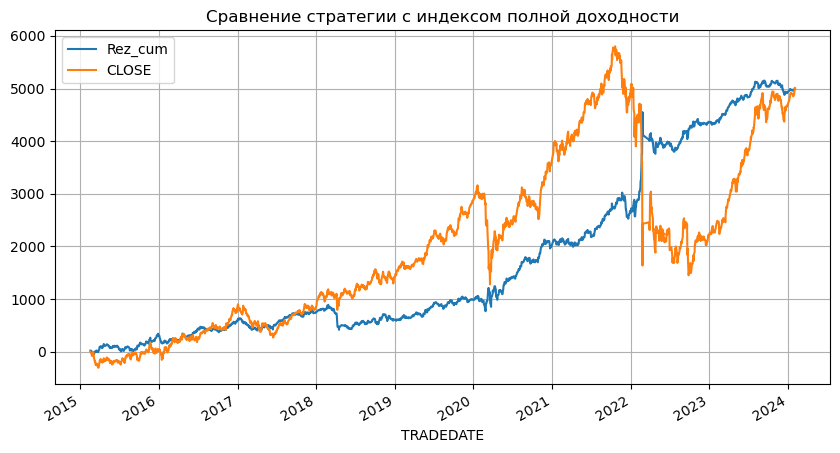

In [82]:
plt.figure();
plot = df.plot(title="Сравнение стратегии с индексом полной доходности",
               grid=True,
               figsize=(10, 5.2),
               layout='constrained');